In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from collections import defaultdict, Counter


pd.options.display.width = 300
pd.options.display.float_format = "{:.3f}".format

%matplotlib inline

In [24]:
from sklearn import model_selection
from sklearn import preprocessing

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, make_scorer


In [525]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA

Format of answer: for each set of data dump a csv le containing matrix with 4 columns
and m2 rows representing binary projection yˆ2 that you think reaches best AUC (the bigger the
better), NUM (the smaller the better), ASY1 (the smaller the better), ASY2 (the smaller the
better) respectively to le named task1_${dataset id}_ans.csv, e.g. task1_10_ans.csv.



* Check for outliers in X
* Filter out unnecessary features

__Warning Normalizing data__: For many estimators, including the SVMs, having datasets with unit standard deviation for each feature is important to get good prediction.

In [450]:
def load_task_input(dataset_id):
    df_X_train = pd.read_csv("/Users/mshevelev/Downloads/aduenko_ml/task1/data/task1_%d_learn_X.csv" % dataset_id, sep=" ", header=None)
    df_y_train = pd.read_csv("/Users/mshevelev/Downloads/aduenko_ml/task1/data/task1_%d_learn_y.csv" % dataset_id, sep=" ", header=None)
    df_X_test = pd.read_csv("/Users/mshevelev/Downloads/aduenko_ml/task1/data/task1_%d_test_X.csv" % dataset_id, sep=" ", header=None)
    df_X_train.columns = ["X%d" % (col+1) for col in df_X_train.columns]
    df_y_train.columns = ["y%d" % (col+1) for col in df_y_train.columns]
    df_y_train = df_y_train["y1"]
    df_X_test.columns = ["X%d" % (col+1) for col in df_X_test.columns]

    data = {
        "X": df_X_train,
        "y": df_y_train,
        "X_test": df_X_test,
    }
    data["Xy"] = pd.concat([data["X"], data["y"]], axis='columns')
    assert data["X"].shape[0] == data["y"].shape[0]
    assert data["X"].shape[1] == data["X_test"].shape[1]    
    print "X:", data["X"].shape
    print "y:", data["y"].shape
    print "test:", data["X_test"].shape[0]

    return data
  

def build_dataframe_with_answers(auc, num, asy1, asy2):
    df = pd.DataFrame({
        "AUC": auc,
        "NUM": num,
#        "ASY1": asy1,
#        "ASY2": asy2
        "ASY1": LossASY(ASY1),
        "ASY2": LossASY(ASY2),
    })
    return df

def save_task_result(dataset_id, df_answers, base_dir="/Users/mshevelev/Downloads/aduenko_ml/task1/answers"):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    out_path = os.path.join(base_dir, "task1_%d_ans.csv" % dataset_id)
    df_answers.to_csv(out_path, index=False)

In [446]:
# define asy_classification_error
ASY1 = np.array([
    [-10, 10],
    [1, 0]
], dtype='float64')
ASY2 = np.array([
    [-1, 2],
    [1, -1]
], dtype='float64')

def make_asy_loss_function(asy):
    def asy_classification_error(y_true, y_pred):
        C = confusion_matrix(y_true, y_pred, labels=[0, 1])
        assert C.shape == (2, 2)
        return np.sum(C * asy)
    return asy_classification_error

asy1_loss = make_asy_loss_function(ASY1)
asy2_loss = make_asy_loss_function(ASY2)


my_scores = {
    "auc":      make_scorer(metrics.roc_auc_score, greater_is_better=True), 
    "accuracy": make_scorer(metrics.accuracy_score, greater_is_better=True),
    "asy1":     make_scorer(asy1_loss, greater_is_better=False),
    "asy2":     make_scorer(asy2_loss, greater_is_better=False),
}


class LossASY:
    def __init__(self, m_asy):
        assert m_asy.shape == (2, 2)
        self.m_asy = m_asy
    
    @property
    def threshold(self):
        C = self.m_asy
        a = C[0, 1] - C[0, 0]
        b = C[1, 0] - C[1, 1]
        return a / (a + b)

    def loss(self, y_true, y_pred):
        C = confusion_matrix(y_true, y_pred, labels=[0, 1])
        assert C.shape == (2, 2)
        return np.sum(C * self.m_asy)

    def __call__(self, estimator, X, y, greater_is_better=True):
        if greater_is_better is True:
            return -self(estimator, X, y, greater_is_better=False)
        prob_pred = estimator.predict_proba(X)
        y_pred = np.zeros_like(y)
        y_pred[prob_pred[:, 1] > self.threshold] = 1
        res = self.loss(y, y_pred)
        return res
        
ScorerASY1 = make_scorer(LossASY(ASY1), greater_is_better=False)
ScorerASY2 = make_scorer(LossASY(ASY2), greater_is_better=False)


### Task 1

In [491]:
data = load_task_input(2)

X: (1000, 20)
y: (1000,)
test: 1000


491


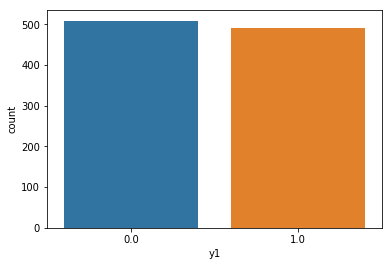

In [492]:
#print data["Xy"].head()
isnull = data["X"].isnull().sum()
dtypes = data["X"].dtypes
assert (dtypes == 'float64').all()
assert (isnull == 0).all()
#print data["X"].describe()
df_X = data["X"]
df_y = data["y"]
df_Xy = data["Xy"]
#print df_X.info()
#df_y.plot(kind='hist')
sns.countplot(x='y', data=data)
print (df_y == 1).sum()

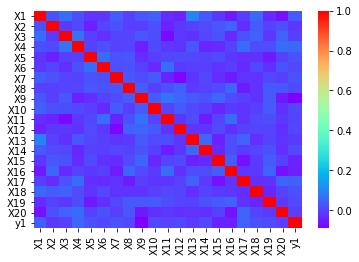

In [524]:
sns.heatmap(df_Xy.corr(method='spearman'), robust=False, cmap=plt.cm.rainbow)
#plt.matshow(df_X.corr(), vmin=-1, vmax=1)
#plt.colorbar()
#plt.pcolor(df_X.corr(method='spearman'))

In [534]:
df_Xy.corr(method='spearman')

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X12,X13,X14,X15,X16,X17,X18,X19,X20,y1
X1,1.000,0.027,0.065,0.021,-0.016,-0.012,0.041,0.003,0.030,0.043,...,-0.043,0.093,0.034,-0.014,-0.055,-0.004,0.055,-0.034,-0.066,0.040
X2,0.027,1.000,-0.008,0.014,-0.046,0.004,0.026,-0.004,-0.005,0.023,...,-0.011,0.002,0.014,0.029,0.051,-0.029,0.040,0.002,0.024,-0.013
X3,0.065,-0.008,1.000,0.072,-0.004,-0.025,0.003,0.006,0.029,0.016,...,-0.011,-0.019,0.008,0.027,-0.034,0.025,0.046,-0.011,0.046,-0.002
X4,0.021,0.014,0.072,1.000,-0.001,0.023,0.000,0.007,-0.044,0.013,...,-0.019,0.030,-0.039,-0.033,-0.000,0.061,0.018,0.018,0.059,0.058
X5,-0.016,-0.046,-0.004,-0.001,1.000,0.060,0.026,0.032,-0.027,-0.001,...,0.012,0.007,0.001,0.014,-0.013,-0.023,-0.020,-0.054,0.001,0.029
X6,-0.012,0.004,-0.025,0.023,0.060,1.000,0.020,0.025,-0.000,-0.032,...,-0.010,-0.003,-0.002,-0.021,-0.004,-0.034,0.009,-0.023,0.026,0.007
X7,0.041,0.026,0.003,0.000,0.026,0.020,1.000,0.031,0.018,0.036,...,-0.085,-0.018,0.008,-0.030,-0.050,-0.018,-0.020,0.010,-0.002,0.027
X8,0.003,-0.004,0.006,0.007,0.032,0.025,0.031,1.000,0.040,-0.002,...,0.048,-0.009,0.001,0.012,0.052,-0.052,-0.019,0.036,0.031,0.012
X9,0.030,-0.005,0.029,-0.044,-0.027,-0.000,0.018,0.040,1.000,0.041,...,0.050,0.035,0.027,0.051,0.013,-0.005,-0.021,0.034,-0.053,-0.091
X10,0.043,0.023,0.016,0.013,-0.001,-0.032,0.036,-0.002,0.041,1.000,...,0.036,0.015,-0.003,-0.036,-0.006,-0.015,-0.002,0.035,-0.026,0.011


/Users/mshevelev/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2882: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


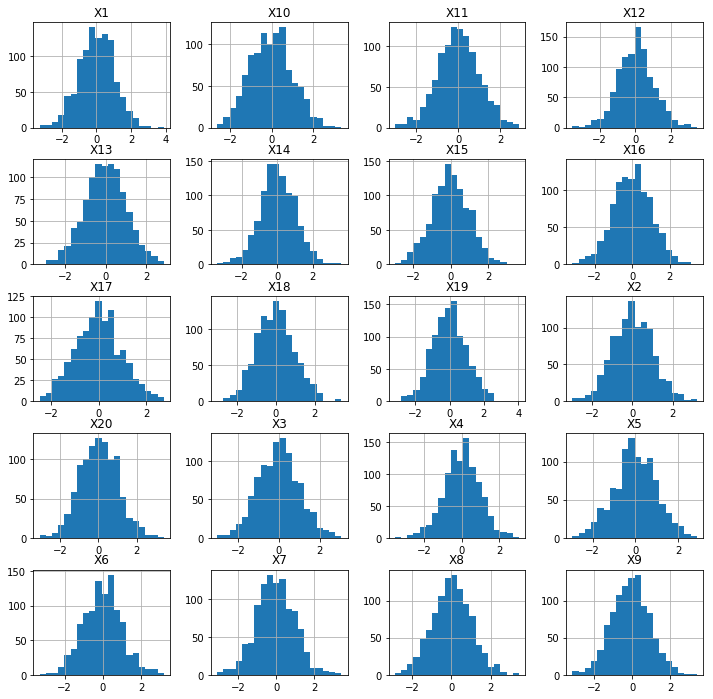

In [494]:
f = plt.figure(figsize=(12,12))
ax = f.gca()
_ = df_X.hist(ax=ax, bins=20)

In [495]:
data["X"].describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
count,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000,1000.000
mean,0.014,0.018,-0.009,0.020,-0.002,-0.014,-0.043,0.021,-0.073,-0.015,0.005,0.043,-0.022,0.034,-0.037,0.011,-0.003,-0.013,-0.008,0.036
std,1.031,0.983,1.009,0.960,0.995,0.993,1.009,0.978,0.991,1.000,0.993,1.012,1.025,1.003,0.996,1.029,0.973,0.972,1.001,0.994
min,-3.294,-2.960,-3.020,-3.578,-2.941,-3.306,-3.109,-2.873,-3.135,-2.605,-3.025,-3.531,-3.273,-3.370,-2.995,-3.189,-2.483,-3.021,-3.198,-3.079
25%,-0.699,-0.671,-0.710,-0.590,-0.607,-0.713,-0.728,-0.617,-0.755,-0.733,-0.652,-0.630,-0.718,-0.597,-0.695,-0.698,-0.693,-0.695,-0.675,-0.627
50%,0.022,0.001,-0.006,0.045,-0.020,-0.003,-0.034,0.042,-0.068,-0.023,-0.002,0.080,0.030,0.021,-0.050,0.021,-0.006,-0.016,-0.015,0.029
75%,0.734,0.700,0.638,0.654,0.693,0.614,0.639,0.667,0.613,0.631,0.672,0.657,0.655,0.713,0.639,0.725,0.619,0.611,0.657,0.741
max,3.894,3.185,3.059,3.078,2.880,3.170,3.427,3.440,3.398,3.348,2.889,3.466,2.867,3.622,3.636,3.453,2.744,3.379,4.050,3.411


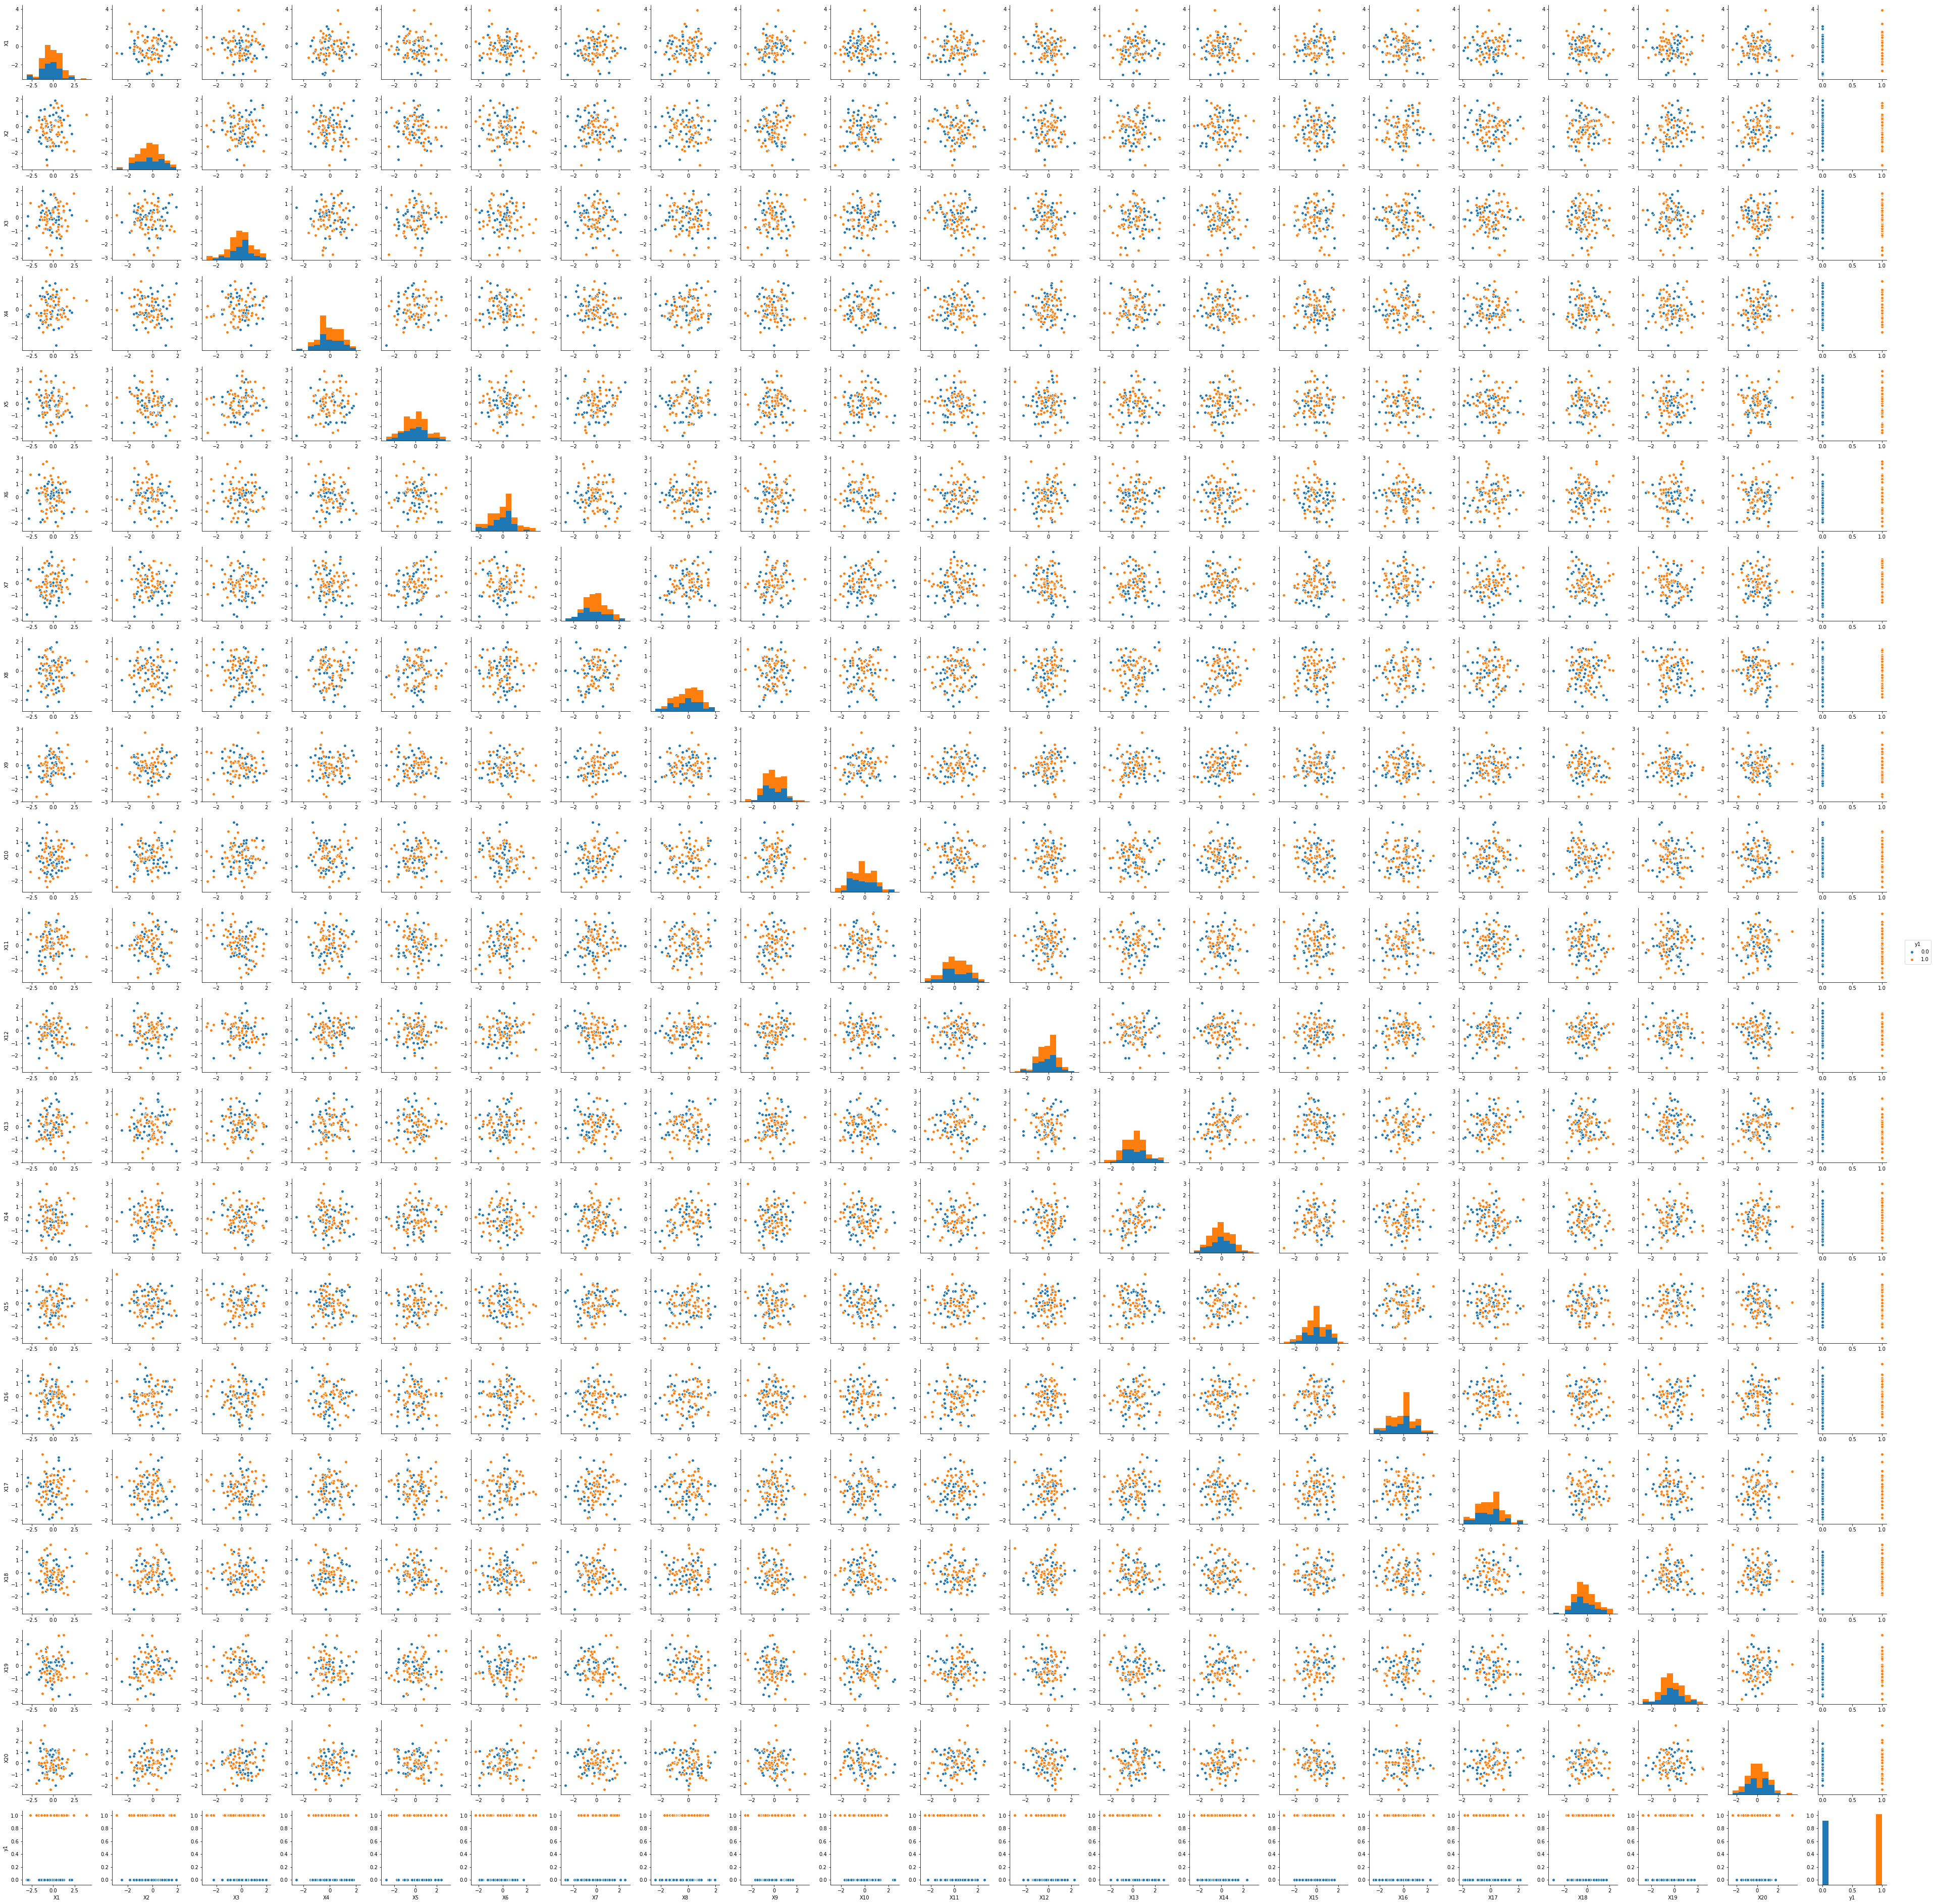

In [496]:
sns.pairplot(data["Xy"].loc[:100], hue="y1", vars=data["Xy"].columns)

### check dummy

In [497]:
# dummy
clf_dummy = DummyClassifier("prior")
#clf_dummy = linear_model.LogisticRegression(penalty='l2')
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

res = model_selection.cross_validate(clf_dummy, data["X"], data["y"], cv=kfold, scoring=my_scores)
print res.keys()

for score in ["auc", "accuracy", "asy1", "asy2"]:
    _scores = res["test_%s" % score]
    print "%10s %6.2f +/- %5.2f" % (score, _scores.mean(), _scores.std())


['train_accuracy', 'train_asy1', 'train_asy2', 'score_time', 'fit_time', 'train_auc', 'test_auc', 'test_accuracy', 'test_asy1', 'test_asy2']
       auc   0.50 +/-  0.00
  accuracy   0.51 +/-  0.00
      asy1 919.80 +/-  3.92
      asy2   3.60 +/-  0.49


Text(0.5,1,u'AUC of dummy classifier')

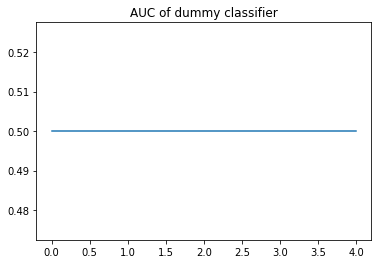

In [498]:
scores = []
for ix_train, ix_test in kfold.split(data["X"], data["y"]):
    X_train = data["X"].loc[ix_train]
    y_train = data["y"].loc[ix_train]
    X_test  = data["X"].loc[ix_test]
    y_test  = data["y"].loc[ix_test]
    clf_dummy.fit(X_train, y_train)
    #clf_dummy.score(X_test, y_test)
    y_predicted = clf_dummy.predict_proba(X_test)[:, 1]
    #print y_predicted
    auc = metrics.roc_auc_score(y_test, y_predicted)
    scores.append(auc)
    
plt.plot(scores)
plt.title("AUC of dummy classifier")

#@fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predicted, )
#auc1 = auc(fpr, tpr)
#auc2 = metrics.roc_auc_score(y_test, y_predicted)
#print auc1, auc2
#plt.plot(fpr, tpr)

In [499]:
### 

PCA:
    explained  cumsum
0       0.064   0.064
1       0.061   0.125
2       0.058   0.183
3       0.057   0.241
4       0.057   0.297
5       0.055   0.352
6       0.054   0.406
7       0.053   0.459
8       0.052   0.511
9       0.050   0.561
10      0.049   0.610
11      0.047   0.657
12      0.047   0.704
13      0.046   0.750
14      0.044   0.795
15      0.043   0.838
16      0.042   0.879
17      0.041   0.921
18      0.040   0.961
19      0.039   1.000


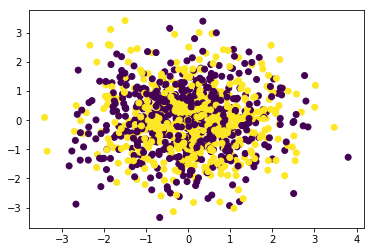

In [500]:
pca = Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("pca", PCA(n_components=None, random_state=0)),
        ])
#pca = PCA(n_components=2)



pca.fit(data["X"])
X_pca2 = pca.transform(data["X"])

plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=data["y"])
print "PCA:"
df_pca = pd.DataFrame({"explained": pca.named_steps['pca'].explained_variance_ratio_})
df_pca["cumsum"] = df_pca["explained"].cumsum()
print df_pca


0.535669586984
{'clf__C': 1.0}


,clf__C,mean_score
0,0.000,0.509
1,0.000,0.509
2,0.000,0.509
3,0.000,0.509
4,0.000,0.509
5,0.000,0.509
6,0.000,0.509
7,0.001,0.509
8,0.010,0.509
9,0.100,0.527


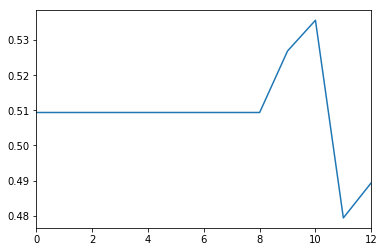

In [537]:
clf = Pipeline([
    ("scale", preprocessing.StandardScaler()),
#    ("clf", LogisticRegression(penalty='l1')),
#    ("clf", RandomForestClassifier()),
#    ("clf", GaussianNB())
    ("clf", SVC(probability=False, kernel='sigmoid', )),

])

hyperparams = {
   "clf__C":    np.logspace(-10, 2, 13),
#    "clf__gamma": np.logspace(-5, 2, 7),
#    "clf__penalty": ["l1", "l2"],
}

# hyperparams = {
#                  'clf__n_estimators': [5, 10, 15, 20, 100, 200],
#                  'clf__max_depth': [2, 5, 7, 9, 10]
# }
    
kfold_outer = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
kfold_inner = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

split_iter = kfold_outer.split(data["X"], data["y"])
ix_development, ix_evaluation = next(split_iter)
X = data["X"].loc[ix_development]
y = data["y"].loc[ix_development]
X_eval = data["X"].loc[ix_evaluation]
y_eval = data["y"].loc[ix_evaluation]

clf = model_selection.GridSearchCV(clf, param_grid=hyperparams, cv=kfold_inner, scoring=my_scores["accuracy"], n_jobs=-1)
clf.fit(X, y)
print clf.best_score_
print clf.best_params_

df = pd.DataFrame(clf.cv_results_['params'])
df["mean_score"] = clf.cv_results_['mean_test_score']




#df = df.pivot_table(columns="clf__penalty", values="mean_score", index="clf__C")
#df.pivot_table( values="mean_score", index=["clf__C"], columns=["clf__gamma"])
#df.pivot_table( values="mean_score", index=["clf__C"])
df.pivot_table( values="mean_score", index=["clf__C"])


df.reset_index(drop=True)["mean_score"].plot()
df
#clf0

In [533]:
for clf0 in [DummyClassifier(strategy='most_frequent').fit(X, y), clf.best_estimator_]:
#     prob_pred = clf0.predict_proba
# #y_pred = clf.best_estimator_.predict(X_eval)
    print my_scores["accuracy"](clf0, X_eval, y_eval)


0.507462686567
0.492537313433


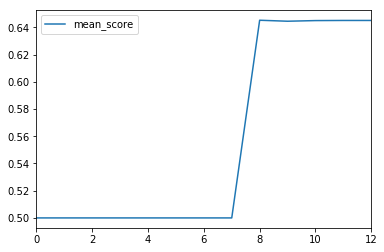

In [257]:
df.pivot_table( values="mean_score", index="clf__C").reset_index(drop=True).plot()

In [22]:
#clf = RandomForestClassifier()
#clf = KNeighborsClassifier(weights="distance")
#clf = svm.SVC(kernel='poly', probability=True)

kfold = model_selection.KFold(n_splits=5, shuffle=False)

scores = []
aucs = []
l_roc = []

d_y = defaultdict(list)
d_prob = defaultdict(list)


clf = LogisticRegression(penalty='l2', )
#clf = SVC(kernel='linear', probability=True)
scaler = preprocessing.StandardScaler()
clf0 = Pipeline([("scale", scaler), 
#                 ("pca", PCA(n_components=4, random_state=0)),
                 ("clf", clf),
                ])
params = {
    "clf__C": np.logspace(-10, 2, 13),
#    "gamma": np.logspace(-10, 2, 13),
#    "n_neighbors": range(1, 20)
}


gs = model_selection.GridSearchCV(clf0, param_grid=params, cv=kfold)

for ix_train, ix_test in kfold.split(data["X"], data["y"]):
    X_train = data["X"].loc[ix_train]
    y_train = data["y"].loc[ix_train]
    X_test  = data["X"].loc[ix_test]
    y_test  = data["y"].loc[ix_test]
    d_y["real"].extend(y_test)
    
    i_scores = []
    i_aucs = []

    for i, C in enumerate(params["clf__C"]):
        clf0.set_params(clf__C = C)        
        clf0.fit(X_train, y_train)
        prob_predicted = clf0.predict_proba(X_test)[:, 1]
        y_predicted = clf0.predict(X_test)
        d_y[i].extend(y_predicted)
        d_prob[i].extend(prob_predicted)

        _roc = pd.Series(tpr, index=fpr)
        l_roc.append(_roc)
        _score = metrics.accuracy_score(y_test, y_predicted)
        _auc = metrics.roc_auc_score(y_test, prob_predicted)
        i_scores.append(_score)
        i_aucs.append(_auc)
    scores.append(i_scores)
    aucs.append(i_aucs)

#       _scores = model_selection.cross_val_score(clf, data["X"], data["y"], cv=kfold)
#    model_selection.cross_validate(clf, )
#     scores.append(_scores)

def plot_scores(m_scores, xticks=None, title=None, use_median=False):
    f = plt.figure()
    ax = f.gca()
    m_scores = np.array(m_scores)
    score_mean = np.mean(m_scores, axis=0)
    score_std = np.std(m_scores, axis=0)
    score_median = np.median(m_scores, axis=0)
    score_25 = np.percentile(m_scores, 25, axis=0)
    score_75 = np.percentile(m_scores, 75, axis=0)

    if xticks is None:
        xticks = np.arange(len(score_mean))

    if use_median:
        ax.plot(xticks, score_median)
        ax.fill_between(xticks, score_25, score_75, alpha=0.15)
    else:
        ax.plot(xticks, score_mean)
        ax.fill_between(xticks, score_mean-score_std, score_mean+score_std, alpha=0.15)
            
    if title is None:
        title = ""
    ax.set_title(title)

plot_scores(scores, title="accuracy")
plot_scores(aucs, title="auc")
    
#plt.fill_between(xticks, score_mean-score_std, score_mean+score_std, alpha=0.15)
#plt.plot(xticks, score_mean+score_std)
#plt.plot(xticks, score_mean-score_std)


#plt.plot(scores)
# #clf.fit(X_train, y_train)
# #clf.score(X_test, y_test)

NameError: name 'tpr' is not defined

In [507]:
gs.fit(data["X"], data["y"])

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [508]:
gs.cv_results_

/Users/mshevelev/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split3_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mshevelev/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split4_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'mean_fit_time': array([ 0.00262251,  0.00211401,  0.00206008,  0.00195022,  0.00208383,
         0.00200644,  0.00195518,  0.00207119,  0.00196342,  0.00203519,
         0.00225964,  0.00208683,  0.00207057]),
 'mean_score_time': array([ 0.00054255,  0.00047116,  0.00042782,  0.00043459,  0.0004148 ,
         0.0004014 ,  0.00036983,  0.00036597,  0.00036077,  0.00035715,
         0.00037642,  0.00038791,  0.00035949]),
 'mean_test_score': array([ 0.626,  0.626,  0.626,  0.626,  0.626,  0.626,  0.626,  0.625,
         0.627,  0.625,  0.623,  0.623,  0.623]),
 'mean_train_score': array([ 0.645  ,  0.645  ,  0.645  ,  0.645  ,  0.645  ,  0.64475,
         0.646  ,  0.6455 ,  0.644  ,  0.642  ,  0.64125,  0.641  ,  0.641  ]),
 'param_clf__C': masked_array(data = [1e-10 1.0000000000000001e-09 1e-08 9.9999999999999995e-08
  9.9999999999999995e-07 1.0000000000000001e-05 0.0001 0.001 0.01
  0.10000000000000001 1.0 10.0 100.0],
              mask = [False False False False False False False 

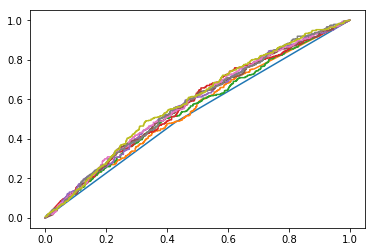

In [457]:
for i in d_prob.keys():
    fpr, tpr, thresholds = metrics.roc_curve(d_y["real"], d_prob[i])
    plt.plot(fpr, tpr, label=str(i))

In [445]:
Counter(d_y[15])

Counter({0.0: 553, 1.0: 447})

(22, 20)
      X1    X2    X3    X4    X5    X6    X7    X8    X9   X10   X11   X12   X13   X14   X15   X16   X17   X18   X19   X20
0  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
1  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
2  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
3  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
4  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
5  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
6  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
7  0.00

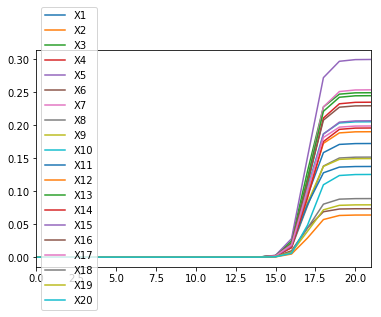

In [261]:
coefs = []
for C in C_s:
    clf.set_params(C=C).fit(X_train, y_train)
    coefs.append(clf.coef_[0])
coefs = np.array(coefs)
print coefs.shape
coefs = pd.DataFrame(np.array(coefs), columns=df_X.columns)
    
coefs.plot()
plt.legend(loc='center left')
print coefs


In [79]:
np.logspace(-5, 1, 10)

array([  1.00000000e-05,   4.64158883e-05,   2.15443469e-04,
         1.00000000e-03,   4.64158883e-03,   2.15443469e-02,
         1.00000000e-01,   4.64158883e-01,   2.15443469e+00,
         1.00000000e+01])